In [1]:
import torch
from torchvision import datasets

import matplotlib.pyplot as plt

In [2]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False)

In [3]:
x_train = torch.stack([x for x in trainset.data]).float()
y_train = torch.stack([y for y in trainset.targets])
x_test = torch.stack([x for x in testset.data]).float()
y_test = torch.stack([y for y in testset.targets])

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

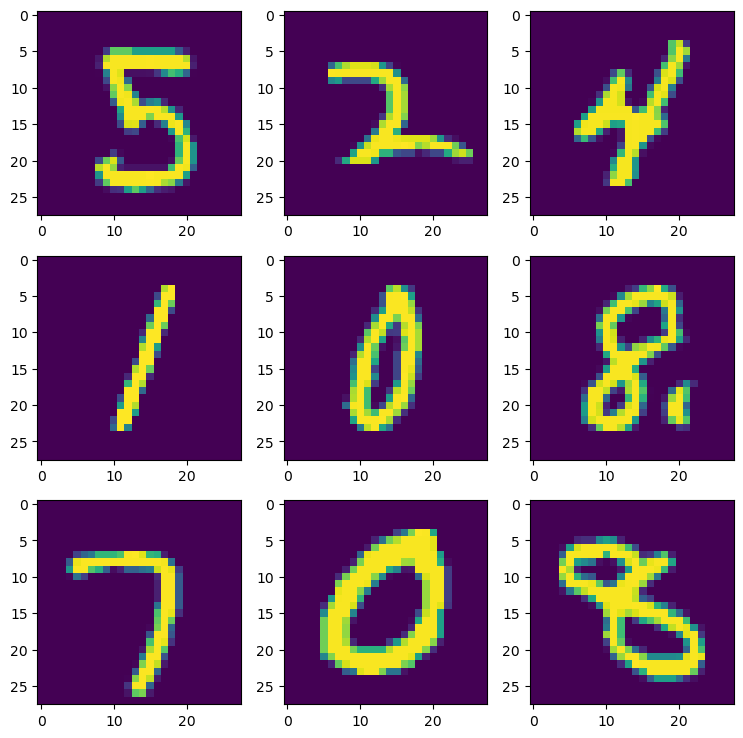

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.ravel()

for i, j in enumerate(torch.randint(0, 60000, (9,))):
    axs[i].imshow(x_train[int(j)])
plt.show()

In [5]:
n_classes = len(set([y.item() for y in y_train]))

x_train_r = x_train.view(x_train.shape[0], -1)
x_test_r = x_test.view(x_test.shape[0], -1)

print(x_train_r.shape, x_test_r.shape, y_train.shape, y_test.shape)

n_samples = x_train_r.shape[0]
n_features = x_train_r.shape[1]

print(n_samples, n_features, n_classes)

torch.Size([60000, 784]) torch.Size([10000, 784]) torch.Size([60000]) torch.Size([10000])
60000 784 10


In [6]:
# Define the Model

class MyModel(torch.nn.Module):
    def __init__(self, n_features, n_classes):
        super(MyModel, self).__init__()

        self.linear1 = torch.nn.Linear(n_features, 512)
        self.linear2 = torch.nn.Linear(512, 256)
        self.linear3 = torch.nn.Linear(256, n_classes)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)

        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.zeros_(self.linear2.bias)
        torch.nn.init.zeros_(self.linear3.bias)
        

    def forward(self, x):
        x = torch.tanh(self.linear1(x))
        x = torch.tanh(self.linear2(x))
        x = self.linear3(x)
        # no need for softmax layer/activation here as Pytorch's implementation of CrossEntropy loss include softmax so you only need logits
        return x
    
    
model = MyModel(n_features=n_features, n_classes=n_classes)
parameters = sum(p.numel() for p in model.parameters())
print(parameters)

535818


In [7]:
loss_fn = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.01)

In [8]:
EPOCHS = 100
BATCH_SIZE = 128

losses = []
accuracies = []

for epoch in range(EPOCHS):
    print(f"Training Epoch {epoch+1}")
    epoch_loss = []
    epoch_acc = []
    
    batches = torch.split(torch.randperm(n_samples), BATCH_SIZE)

    for batch_idx in batches:
        
        optimiser.zero_grad()
        outputs = model(x_train_r[batch_idx])
        
        pred = torch.argmax(outputs, dim=1)
        accuracy = (pred == y_train[batch_idx]).float().mean()
        epoch_acc.append(accuracy)
        
        loss = loss_fn(outputs, y_train[batch_idx])
        epoch_loss.append(loss)
        loss.backward()
        
        optimiser.step()

    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    losses.append(epoch_loss.item())
    print(f"     Loss is {epoch_loss.item()}")

    epoch_acc = sum(epoch_acc) / len(epoch_acc)
    accuracies.append(epoch_acc.item())
    print(f"     Accuracy is {epoch_acc.item()*100:.2f}")

Training Epoch 1


     Loss is 0.5722227692604065
     Accuracy is 83.90
Training Epoch 2
     Loss is 0.31156420707702637
     Accuracy is 91.11
Training Epoch 3
     Loss is 0.25748130679130554
     Accuracy is 92.61
Training Epoch 4
     Loss is 0.2280021607875824
     Accuracy is 93.57
Training Epoch 5
     Loss is 0.20975655317306519
     Accuracy is 93.98
Training Epoch 6
     Loss is 0.19426944851875305
     Accuracy is 94.47
Training Epoch 7
     Loss is 0.18335989117622375
     Accuracy is 94.71
Training Epoch 8
     Loss is 0.16943560540676117
     Accuracy is 95.21
Training Epoch 9
     Loss is 0.16126205027103424
     Accuracy is 95.34
Training Epoch 10
     Loss is 0.151619553565979
     Accuracy is 95.65
Training Epoch 11
     Loss is 0.14830376207828522
     Accuracy is 95.67
Training Epoch 12
     Loss is 0.14380964636802673
     Accuracy is 95.83
Training Epoch 13
     Loss is 0.13404840230941772
     Accuracy is 96.11
Training Epoch 14
     Loss is 0.13095881044864655
     Accuracy is 

In [9]:
# glorot/xavier uniform loss 0.0529 acc 98.31
# glorot/xavier normal loss 0.0549 acc 98.30

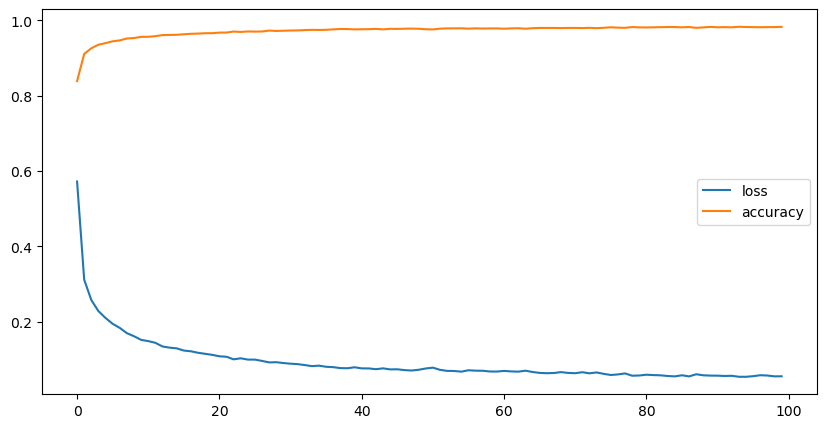

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(losses, label='loss')
ax.plot(accuracies, label='accuracy')
ax.legend()

plt.show()

In [11]:
# Switch to evaluation mode
model.eval()

with torch.no_grad():
    outputs = model(x_test_r)

    pred = torch.argmax(outputs, dim=1)
    accuracy = (pred == y_test).float().mean()
    loss = loss_fn(outputs, y_test)
    
    print(f"Test Loss is {loss.item()}")
    print(f"Test Accuracy is {accuracy.item()*100:.2f}")

Test Loss is 0.09836628288030624
Test Accuracy is 96.86
